# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


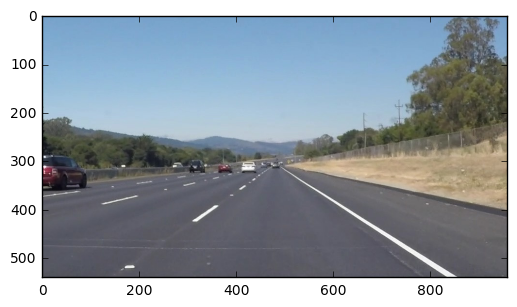

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold=50, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho=2, theta=np.pi/180, threshold=15, min_line_len=40, max_line_gap=20):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

_last_x = [None]*4

def reset_pipeline():
    global _last_x
    _last_x = [None]*4
    return

## draw_lines

In [4]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=5, α=0.):
    """
    Draws an estimate of the lane markers based on the passed in 
    `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    
    The lane marker positions are estimated as the line fitted
    to the endpoints of the passed in `lines`.
    `lines` are first filtered and then partitioned into two
    depending on the line slope with one line for the left
    and one for the right side of the car. 
    
    `α` is a smoothing (filter) parameter, which averages 
    the current estimate with previous observations.
    `α` is applied to the estimated x coordinates of the two lanes. 
    For example, the left lane x coordinate would be set as:
    x1 = α*last_x1 + (1-α)*x1
    """
    global _last_x

    ysize, xsize, _ = img.shape
   
    ymin = np.min(lines[:, 0, [1, 3]].flatten()) # highest point in the image where lines end

    calc_slope = lambda x1, y1, x2, y2: (y2-y1)/(x2-x1+np.spacing(1))
    def get_slopes(xs):
        helper_fn = lambda x: calc_slope(*(x[0] if len(x.shape) > 1 else x))
        return np.array(list(map(helper_fn, xs)))

    # first, filter out lines that have small absolute slope
    lines = lines[np.absolute(get_slopes(lines)) > 0.55, :, :]

    # group lines into 2 clusters - negative and positive slopes respectively
    g1, g2 = [], []
    for line in lines:
        if calc_slope(*line[0]) < 0:
            g1.append(line)
        else:
            g2.append(line)
    
    g1, g2 = np.array(g1), np.array(g2)
    
    # construct a representative line from each cluster
    lines_to_draw = []
    
    # returns [x1, y1, x2, y2] of the line fitted to lines
    def calc_line(lines, last_x1=None, last_x2=None, x_min=0, x_max=xsize-1):
        # first, remove outliers if there are enough samples to run stats
        if len(lines) > 5: 
            slopes = get_slopes(lines)
            lines = lines[abs(slopes-np.mean(slopes)) < 1.25*np.std(slopes)]
        
        if len(lines) > 0:
            xs, ys = lines[:, :, [0, 2]].flatten(), lines[:, :, [1, 3]].flatten()
            # fit a line through all points in the cluster
            m, b = np.polyfit(xs, ys, 1)
            # draw a line from the bottom of the image (ysize) to the highest point (ymin)
            # using the fitted line coefficients
            x1 = min(max((ysize-b)/m, x_min), x_max)
            x2 = min(max((ymin-b)/m, x_min), x_max)
            
            if last_x1 is not None:
                x1 = α*last_x1 + (1-α)*x1

            if last_x2 is not None:
                x2 = α*last_x2 + (1-α)*x2
                
            return np.array([x1, ysize, x2, ymin]).astype(np.int32), m, b
        else: 
            # use past estimate if no lines were detected/passed in
            if last_x1 is not None and last_x2 is not None:
                m = calc_slope(last_x1, ysize, last_x2, ymin)
                b = ysize - m*last_x1
                return np.array([last_x1, ysize, last_x2, ymin]), m, b
    
    try:
        line1, m1, b1 = calc_line(g1, last_x1=_last_x[0], last_x2=_last_x[1])
        line2, m2, b2 = calc_line(g2, last_x1=_last_x[2], last_x2=_last_x[3])
    
        # check if line intersect and if so shorten the lines
        if line1[2] >= line2[2]:
            x_intersect = (b2-b1)/(m1-m2)
            line1[2] = 0.98*x_intersect
            line2[2] = 1.02*x_intersect

        _last_x = np.hstack((line1[[0,2]], line2[[0,2]])).tolist()

        for x1,y1,x2,y2 in [line1, line2]:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    except: # not enough lines detected to estimate lane
        return


def draw_lines_img(shape, lines, α=0.):
    """
    Calls draw_lines with a blank image array of `shape` and passes it to draw_lines.
    `α` is a smoothing (filter) parameter (refer to draw_lines).
    
    Returns an image with the lane estimates drawn over.
    """
    line_img = np.zeros(shape, dtype=np.uint8)
    draw_lines(line_img, lines, α=α)
    return line_img

## Image pipeline

In [5]:
def image_pipeline(image, α=0.):
    """
    Takes an `image` and runs it through the processing pipeline
    to get estimates of the car lane position in the image.
    
    `α` is a smoothing (filter) parameter (refer to draw_lines).
    
    reset_pipeline must be called between independent series of images
    to clear filter data.
    
    The pipeline is as follows:
    1. Convert image from RGB to HLS and keep a copy of the result.
       All subsequent operations are applied to both the original and
       the HLS version unless otherwise specified.
    2. Apply grayscale transform.
    3. Apply a Gaussian blur.
    4. Use the Canny transform for edge detection.
    5. Use a quadrilateral to mask out most of the image that is not
       immediately in front and to the side of the car.
    6. Apply the probabilistic Hough line transform to detect lines.
    7. Draw an estimate of the lane borders based on the detected lines.
       Please refer to draw_lines for more information on the algorithm.
       
    Note that at the last step, draw_lines is called with the output
    of the Hough line transform on the original and HLS version of the image.
    I have found that this improves detection as the errors on the two images
    are not perfectly correlated and the errors are averaged out to some extent.
    """
    ysize, xsize, _ = image.shape
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    gray, gray_hls = [grayscale(ig) for ig in [image, hls]]
    blurred, blurred_hls = [gaussian_blur(ig) for ig in [gray, gray_hls]]
    edges, edges_hls = [canny(ig) for ig in [blurred, blurred_hls]]
    quadrilateral = np.array([[(0, ysize*0.95), (xsize*0.4, 0.6*ysize), (xsize*0.6, 0.6*ysize), (xsize, ysize*0.95)]], dtype=np.int32)
    region_masked, region_masked_hls = [region_of_interest(ig, quadrilateral) for ig in [edges, edges_hls]]
    lines, lines_hls = [hough_lines(ig) for ig in [region_masked, region_masked_hls]]
    lines_img_combined = draw_lines_img(image.shape, np.vstack((lines, lines_hls)), α=α)
    
    return weighted_img(lines_img_combined, image)


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteRight.jpg']

run your solution on all test_images and make copies into the test_images directory).

In [7]:
os.listdir("test_images/")[0]

'solidYellowCurve.jpg'

### Playground

This is a playground to experiment with each step of the pipeline

In [8]:
reset_pipeline()
#image = mpimg.imread(os.path.join("test_images/", os.listdir("test_images/")[1]))
ysize, xsize, _ = image.shape
quadrilateral = np.array([[(0, ysize*0.95), (xsize*0.4, 0.6*ysize), (xsize*0.6, 0.6*ysize), (xsize, ysize*0.95)]], dtype=np.int32)

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
gray, gray_hls = [grayscale(ig) for ig in [image, hls]]
blurred, blurred_hls = [gaussian_blur(ig) for ig in [gray, gray_hls]]
edges, edges_hls = [canny(ig) for ig in [blurred, blurred_hls]]
region_masked, region_masked_hls = [region_of_interest(ig, quadrilateral) for ig in [edges, edges_hls]]
lines, lines_hls = [hough_lines(ig) for ig in [region_masked, region_masked_hls]]
    
lines_img, lines_img_hls = [draw_lines_img(image.shape, ig, α=0.) for ig in [lines, lines_hls]]
lines_img_combined = draw_lines_img(image.shape, np.vstack((lines, lines_hls)), α=0.)


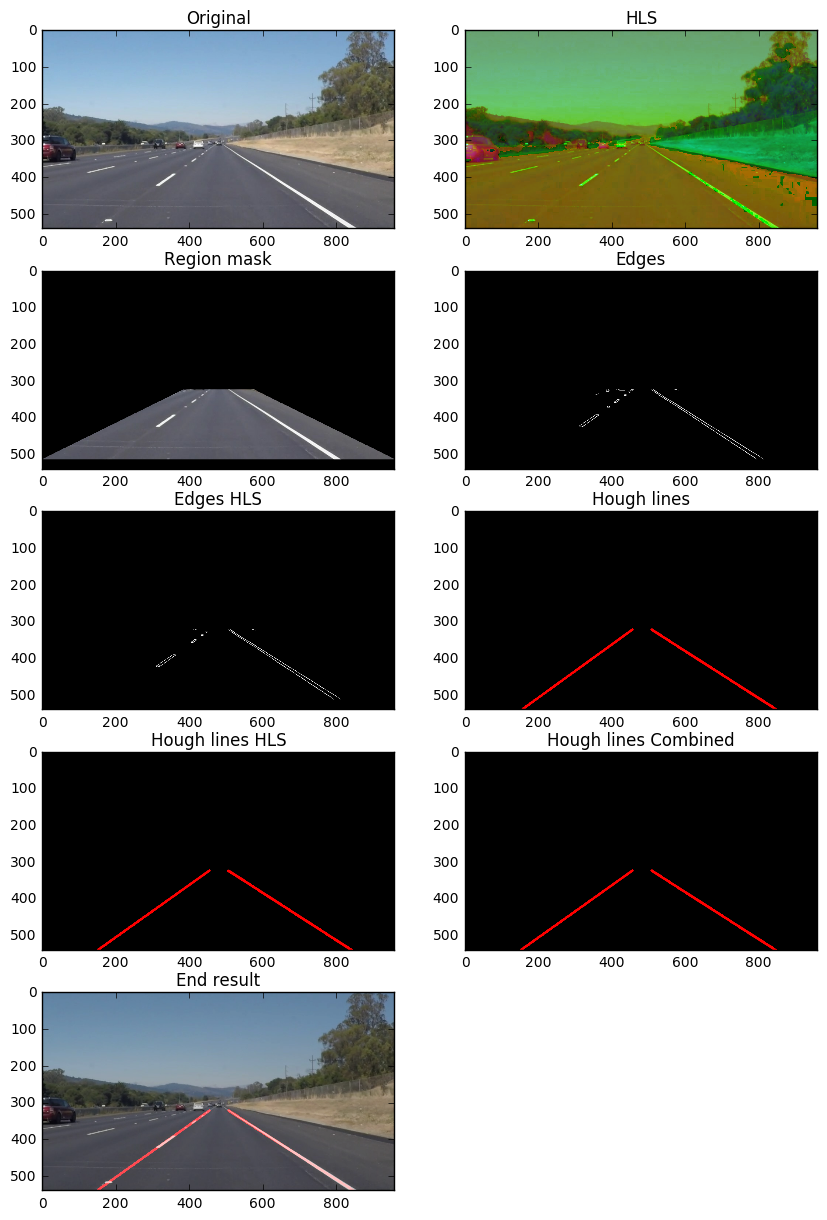

In [9]:
plt.figure(figsize=(10, 15))
plt.subplot(5, 2, 1)
plt.title('Original')
plt.imshow(image)
plt.subplot(5, 2, 2)
plt.title('HLS')
plt.imshow(hls)
plt.subplot(5, 2, 3)
plt.title('Region mask')
plt.imshow(region_of_interest(image, quadrilateral))
plt.subplot(5, 2, 4)
plt.title('Edges')
plt.imshow(region_masked, cmap='gray')
plt.subplot(5, 2, 5)
plt.title('Edges HLS')
plt.imshow(region_masked_hls, cmap='gray')
plt.subplot(5, 2, 6)
plt.title('Hough lines')
plt.imshow(lines_img, cmap='gray')
plt.subplot(5, 2, 7)
plt.title('Hough lines HLS')
plt.imshow(lines_img_hls, cmap='gray')
plt.subplot(5, 2, 8)
plt.title('Hough lines Combined')
plt.imshow(lines_img_combined, cmap='gray')
plt.subplot(5, 2, 9)
plt.title('End result')
weighted = weighted_img(lines_img_combined, image)
plt.imshow(weighted)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    return image_pipeline(image, α=0.825)

Let's try the one with the solid white lane on the right first ...

In [12]:
reset_pipeline()
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:05<00:00, 42.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 25.4 s, sys: 288 ms, total: 25.7 s
Wall time: 5.44 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
reset_pipeline()
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:16<00:00, 42.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 18s, sys: 680 ms, total: 1min 19s
Wall time: 16.4 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Thoughs and potential next steps

The pipeline and the underlying algorithm in its current form perform satisfactory on the test images and videos. An important step to improving it would be to gather more test data (images and videos) to better understand the limitations of the model. Otherwise there is a significant risk of overfitting.

As it is the pipeline uses a series of simple transformations with well-known computer vision algorithms, which deliver a good starting point for lane detection.

The limitations become clear when the pipeline is used on the challenge video, where the leftmost lane marker has partially faded and its yellow color does not provide sufficient contrast at several points in the video.

One of the most important improvement was the addition of a simple filter, which averages the last estimate of the lane position with the current one. This uses the fact that the images in a video are not independent. The approach improves stability and can help reduce errors and improve the running estimate of the lane lines.
The filter step can be further improved, for example, by dynamically adjusting the α paremeter with the size of the jump in angle and coordinates of the line estimates, or switching to a better estimator, such as a variant of the Kalman filter.

Similarly, there are several parameters used for the transform and filtering errors that are at present manually set to work well for the test data at hand. It might be useful to add a pre-processing step that dynamically adjusts these paremeter using heuristics and more advanced estimators based on the input camera data and any other sensor or local data (camera quality and position, features of the road markings where the video was recorded, etc).

Some images do not exhibit sufficient contrast for reliable estimation. An example is the challenge video, where the faded yellow line can be hard to detect with changing light conditions. The HLS transform helps a bit, but my expectation is that better camera and image quality and lane color estimation can lead to bigger improvements. For example, the pipeline could further developed to detect that the left lane border has a solid yellow line and focus on detecting the color in subsequent frames.

The quality of the pipeline can be also improved by adding further sensor data to our model. As a simple example, the model can dynamically resize the region of interest in the video to adjust for slope of the road, steering angle, etc. Map data could be used to add position and expected curvature of the road to improve detection.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

The algorithm in this project submission is mostly usable on the challenge video.
There are some larger errors which can be reduced with the suggestions in the reflection section.

In [16]:
reset_pipeline()
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:10<00:00, 25.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 35.9 s, sys: 464 ms, total: 36.4 s
Wall time: 10.7 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))